In [2]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

from datetime import datetime

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (10,8)

In [9]:
df = pd.read_csv('nyc_energy_consumption.csv')
df.index = pd.to_datetime(df['timeStamp'])

In [14]:
df.tail()

timeStamp  demand  precip   temp
timeStamp                                                      
2017-08-12 02:00:00  2017-08-12 02:00:00     NaN  0.0000  70.84
2017-08-12 03:00:00  2017-08-12 03:00:00     NaN  0.0000  70.57
2017-08-12 04:00:00  2017-08-12 04:00:00     NaN  0.0000  69.89
2017-08-12 05:00:00  2017-08-12 05:00:00     NaN  0.0000  68.59
2017-08-12 06:00:00  2017-08-12 06:00:00     NaN  0.0031  67.33

In [17]:
import plotly.express as px

fig = px.line(df, x='timeStamp', y='demand')
fig.update_xaxes(rangeslider_visible=True,
                rangeselector = dict(buttons=list([
                    dict(count=1 ,label='1y',step='year',stepmode='backward'),
                    dict(count=2 ,label='2y',step='year',stepmode='backward'),
                    dict(count=3 ,label='3y',step='year',stepmode='backward'),
                    dict(count=4 ,label='4y',step='year',stepmode='backward'),
                    dict(step='all')
                ]))
                )

### Observation:
1. we can see here some seasonality every year but their is no trend component.
2. we can see the energy consumption is pretty high in july to oct months with is time of summer.

array([<AxesSubplot:xlabel='timeStamp'>, <AxesSubplot:xlabel='timeStamp'>,
       <AxesSubplot:xlabel='timeStamp'>], dtype=object)

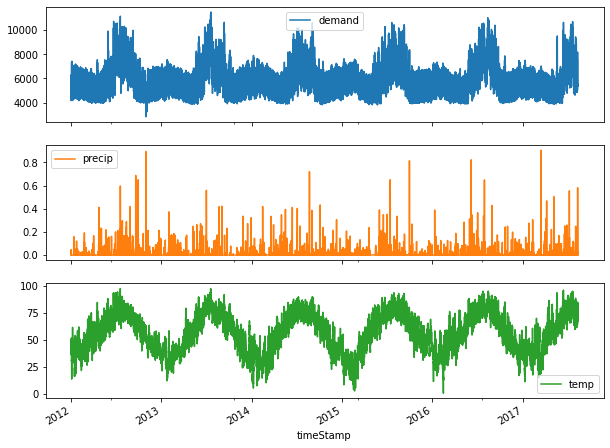

In [28]:
## the data is in hourly level 
df.plot(subplots=True)

### observation:
1. here we can see some +ve correlation b/w the demand and temparature feature 

In [21]:
## missing values
df.isnull().sum()

timeStamp      0
demand        81
precip       230
temp         186
dtype: int64

In [25]:
## where demand is null
df.query('demand != demand').head()

timeStamp  demand  precip   temp
timeStamp                                                      
2012-03-11 02:00:00  2012-03-11 02:00:00     NaN     0.0  37.78
2013-03-10 02:00:00  2013-03-10 02:00:00     NaN     0.0  38.18
2014-03-09 02:00:00  2014-03-09 02:00:00     NaN     0.0  40.86
2015-03-08 02:00:00  2015-03-08 02:00:00     NaN     0.0  36.96
2015-03-11 11:00:00  2015-03-11 11:00:00     NaN     0.0  49.95

In [26]:
## here  demand is not increasing gradualy or sudden high or low so we can forward fill the data.
df['demand'] = df['demand'].fillna(method='ffill')
df['temp'] = df['temp'].fillna(method='ffill')
## but leaving the precip feature right now

array([<AxesSubplot:xlabel='timeStamp'>, <AxesSubplot:xlabel='timeStamp'>,
       <AxesSubplot:xlabel='timeStamp'>], dtype=object)

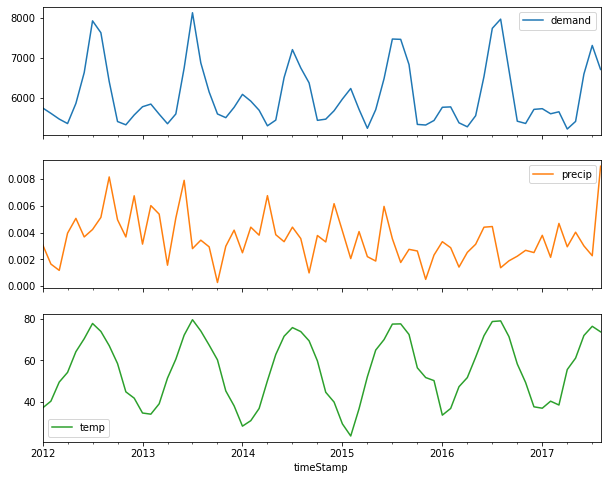

In [29]:
## the data is in hourly level so we resample it to visualize it better
df.resample('m').mean().plot(subplots=True)

In [31]:
## convertind data to monthely level for less noise
df_monthly = df.resample('m').mean()
df_monthly.head()

demand    precip       temp
timeStamp                                   
2012-01-31  5757.495833  0.003116  37.174288
2012-02-29  5622.331609  0.001650  40.448046
2012-03-31  5479.919198  0.001179  49.607917
2012-04-30  5368.945833  0.003959  54.255903
2012-05-31  5867.896102  0.005064  64.188078

## Auto ARIMA Model
1. in ARIMA model we have three parameter p,d,q .
2. p = AR model (lags for your data or correlation of data by itself), 
3. d = error or integrated part (or non seasonal differences to make data stationary) , here we hve stationary data but some time we do not have stationary data so we need to differencate the data with some lag or previous lag to make is stationary.
4. q = MA model (moving average) which is no of lags forcast errors in the predication , means we are taking a forcasting error and basically we are calculating the lags in frocasting error.
5. these parameter can be assume by the acf or pacf (auto correlation plot) and (partial correlation plot), but sometime it is very difficult to find it.

## split train and test 

In [42]:
train = df_monthly[(df_monthly.index.get_level_values(0) >= '2012-01-31') &
                   (df_monthly.index.get_level_values(0) <= '2017-04-30')]

test = df_monthly[(df_monthly.index.get_level_values(0) > '2017-04-30')]

In [34]:
from pmdarima import auto_arima

# m = seasonality duration
model = auto_arima(df_monthly['demand'],
                   m = 12 , seasonal= True,
                   start_P=0, start_q=0 , max_order=4 , test='adf',
                   error_action='ignore',suppress_warnings=True,
                   stepwise=True, trace=True
              )

Performing stepwise search to minimize aic
 ARIMA(2,0,0)(0,0,1)[12] intercept   : AIC=997.347, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=1100.321, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=1023.743, Time=0.25 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=1380.758, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=1021.211, Time=0.06 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=nan sec
 ARIMA(2,0,0)(0,0,2)[12] intercept   : AIC=993.144, Time=0.44 sec
 ARIMA(2,0,0)(1,0,2)[12] intercept   : AIC=995.136, Time=0.44 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(3,0,0)(0,0,2)[12] intercept   : AIC=995.445, Time=0.46 sec
 ARIMA(2,0,1)(0,0,2)[12] intercept   : AIC=994.749, Time=0.44 sec
 ARIMA(1,0,1)(0,0,2)[12] intercept   : AIC=1000.737, Time=0.36 sec
 ARIMA(3,0,1)(0,0,2)[12] intercept   : AIC=998.762, Time=0.49 sec
 ARIMA(2,0,0)(0,0,2)[12]             : AI

In [35]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                   68
Model:             SARIMAX(2, 0, 0)x(0, 0, [1, 2], 12)   Log Likelihood                -490.572
Date:                                 Fri, 01 Oct 2021   AIC                            993.144
Time:                                         09:02:42   BIC                           1006.461
Sample:                                              0   HQIC                           998.420
                                                  - 68                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3721.6223    792.260      4.697      0.000    2168.822    5274.423
ar.L1          0.8586      0.123      6.985      0.000       0.618       1.099
ar.L2         -0.4748      0.142     -3.352      0.001      -0.752      -0.197
ma.S.L12       0.8923      0.137      6.501      0.000       0.623       1.161
ma.S.L24       0.4571      0.206      2.222      0.026       0.054       0.860
sigma2      9.046e+04   1.58e+04      5.726      0.000    5.95e+04    1.21e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 5.55
Prob(Q):                              0.89   Prob(JB):                         0.06
Heteroskedasticity (H):               0.78   Skew:                             0.52
Prob(H) (two-sided):                  0.55   Kurtosis:                         3.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [45]:
model.fit(train['demand'])

ARIMA(order=(2, 0, 0), scoring_args={}, seasonal_order=(0, 0, 2, 12),
      suppress_warnings=True)

In [59]:
## forcasting the 4 future value and we can get accuracy of it by seeing the org 4 value of test
## return_conf retur the confidance interval mean upper bound and lower bound where our predication lyes
forcast = model.predict(n_periods=4,return_conf_int=True)
forcast

(array([5320.83277749, 6194.15059852, 7184.10813026, 7297.99962546]),
 array([[4724.37020414, 5917.29535083],
        [5391.43561763, 6996.86557942],
        [6358.61995324, 8009.59630727],
        [6467.74936159, 8128.24988933]]))

In [51]:
forcast_df = pd.DataFrame(forcast[0] ,index = test.index , columns=['Predication'])
forcast_df

Predication
timeStamp              
2017-05-31  5320.832777
2017-06-30  6194.150599
2017-07-31  7184.108130
2017-08-31  7297.999625

<AxesSubplot:xlabel='timeStamp'>

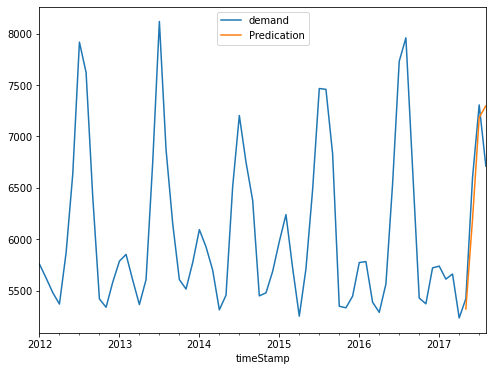

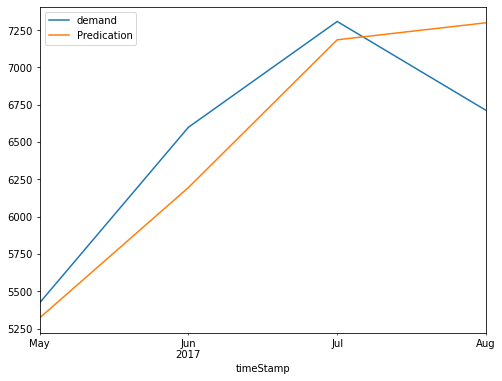

In [63]:
## for ploting 
pd.concat([df_monthly['demand'],forcast_df],axis=1).plot(figsize=(8,6))

# with respect to test data we can see preications
pd.concat([test['demand'],forcast_df],axis=1).plot(figsize=(8,6))

In [66]:
test.tail()

demand    precip       temp
timeStamp                                   
2017-05-31  5421.773060  0.004031  61.115457
2017-06-30  6597.990346  0.003008  71.962625
2017-07-31  7306.861511  0.002272  76.380363
2017-08-31  6711.707542  0.008961  73.730258

In [67]:
## lets predict for the next 10 future days
## but probelm is we do not have index for next 6 days we have only 4 days index as test set so we need to create index first
forcast_range_index = pd.date_range(start='2017-05-31', periods=10 ,freq='M') # with test 4 days and extra 6 days

In [80]:
forcaste_10 = model.predict(n_periods=10 , return_conf_int=True)
forcaste_10

(array([5320.83277749, 6194.15059852, 7184.10813026, 7297.99962546,
        6401.92729264, 5789.92421929, 5693.03965093, 5951.57311183,
        5892.05061164, 5734.60850882]),
 array([[4724.37020414, 5917.29535083],
        [5391.43561763, 6996.86557942],
        [6358.61995324, 8009.59630727],
        [6467.74936159, 8128.24988933],
        [5553.64733239, 7250.20725288],
        [4934.10754042, 6645.74089817],
        [4837.08541556, 6548.99388631],
        [5094.94724222, 6808.19898145],
        [5034.59977919, 6749.50144408],
        [4876.91517798, 6592.30183965]]))

In [71]:
forcast_df = pd.DataFrame(forcaste_10[0],index=forcast_range_index,columns=['Predication'])
forcast_df

Predication
2017-05-31  5320.832777
2017-06-30  6194.150599
2017-07-31  7184.108130
2017-08-31  7297.999625
2017-09-30  6401.927293
2017-10-31  5789.924219
2017-11-30  5693.039651
2017-12-31  5951.573112
2018-01-31  5892.050612
2018-02-28  5734.608509

<AxesSubplot:>

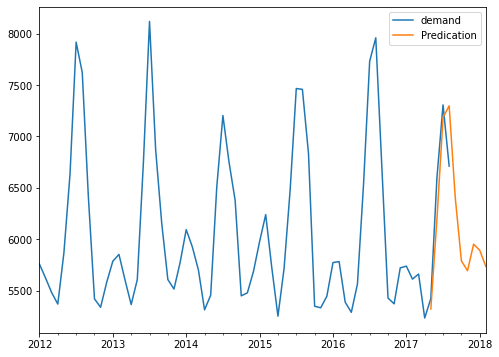

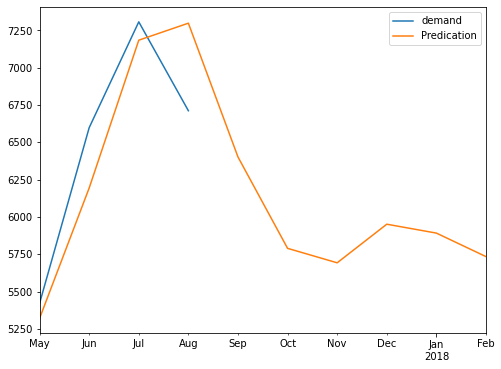

In [75]:
# withwhole data
pd.concat([df_monthly['demand'],forcast_df],axis=1).plot(figsize=(8,6))

# with test
pd.concat([test['demand'],forcast_df],axis=1).plot(figsize=(8,6))

## Confidance Interval
1. sometime our forcaste is not perfect so we need to go with the confiance intervals.
2. confidance interval is a lower and upper bound value wher b/w our predication lyies.
3. we can increse the accuracy predication by adjusting the confidance interval values

In [84]:
lower = pd.Series(forcaste_10[1][:,0] , index=forcast_range_index)
upper = pd.Series(forcaste_10[1][:,1] , index=forcast_range_index)

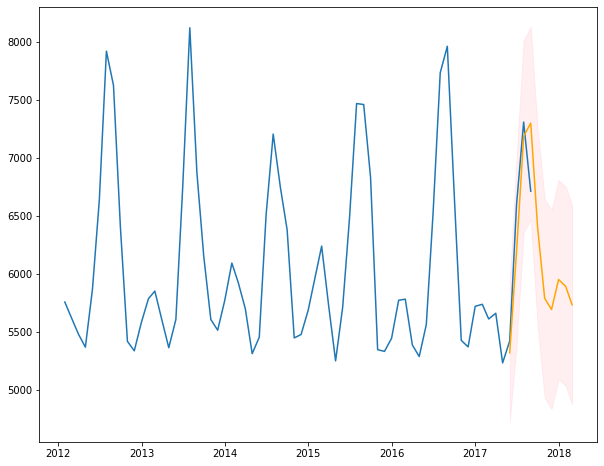

In [97]:
plt.plot(df_monthly['demand'])
plt.plot(forcast_df , color='orange')
plt.fill_between(forcast_range_index,
                lower,
                upper,
                color='pink',
                alpha= 0.25)

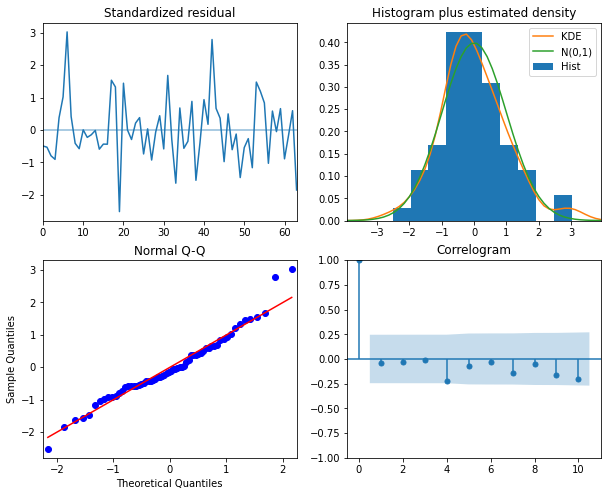

In [98]:
## ploting the diagonstics
output = model.plot_diagnostics()

In [106]:
from sklearn.metrics import mean_squared_error , mean_absolute_error

In [105]:
(mean_squared_error(test.demand,forcast_df[:4].Predication))**0.5

364.7198518324889